In [1]:
import config

from tqdm import tqdm
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel
import torch
import pickle
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
os.chdir(config.DIR_ROOT)

/Users/nad/miniconda3/envs/mobiraph1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from n02_scripts.n15_classification_table_nice import plot_classification_report

In [3]:
ks = [4, 5, 6, 7]

# Logistic Regression

-------Results for 4 kmers--------
Суммарная доля дисперсии: 0.8887380514212965
Лучшие параметры: {'C': 0.1, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая CV F1-macro: 0.7737416721883299
Accuracy: 0.7740619902120718


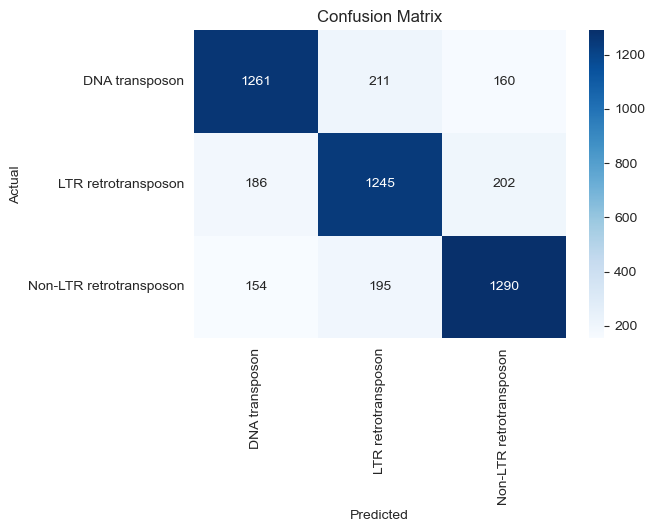

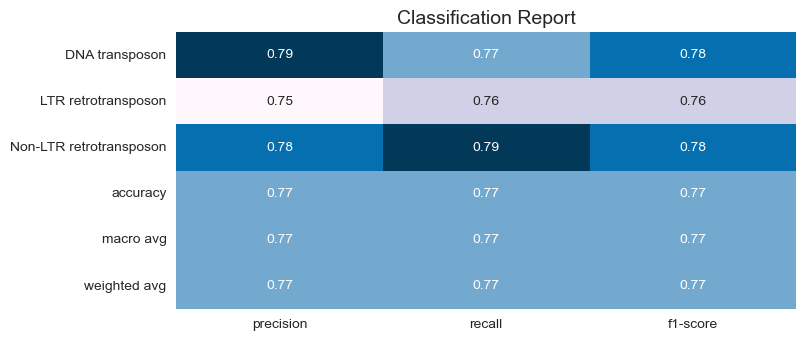

-------Results for 5 kmers--------
Суммарная доля дисперсии: 0.5651096631227855
Лучшие параметры: {'C': 0.01, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая CV F1-macro: 0.7956684567406345
Accuracy: 0.8042414355628059


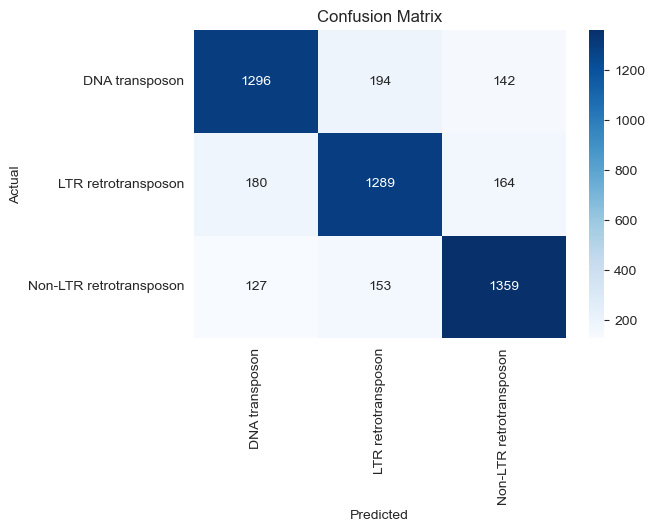

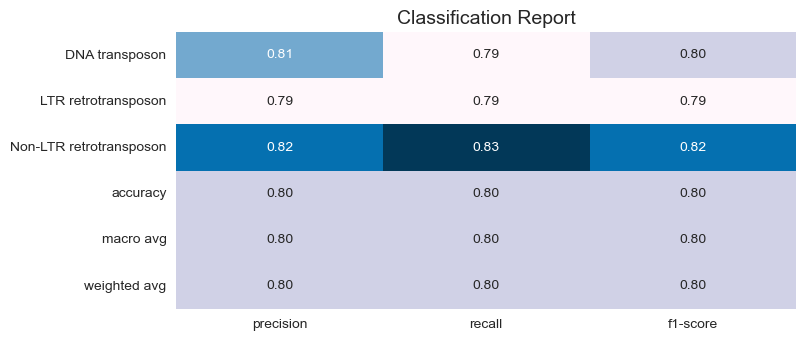

-------Results for 6 kmers--------
Суммарная доля дисперсии: 0.28400982049332996
Лучшие параметры: {'C': 0.01, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая CV F1-macro: 0.8183823080747983
Accuracy: 0.8193311582381729


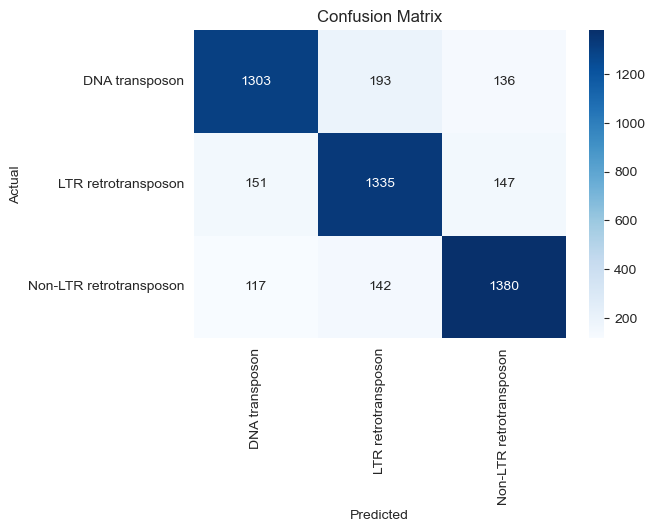

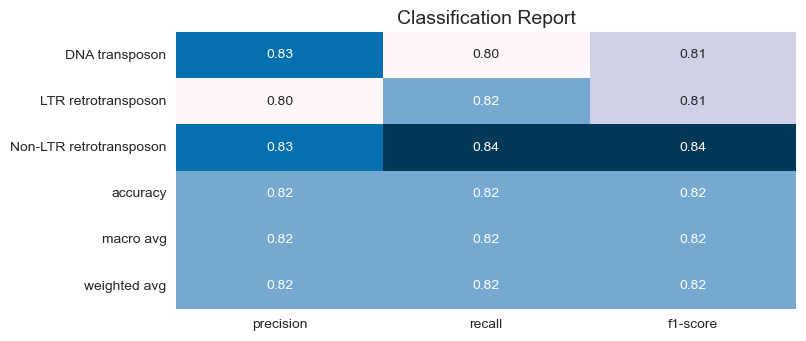

-------Results for 7 kmers--------


In [ ]:
for k in ks:
    print(f'-------Results for {k} kmers--------')
    path_to_df = os.path.join(config.DIR_INCEST_MANY, f"{k}.csv")
    df = pd.read_csv(path_to_df)

    path_to_df_info = os.path.join(config.DIR_INCEST_MANY, "repbase_filtered.csv")
    df_info = pd.read_csv(path_to_df_info)

    df_merge = pd.merge(df, df_info, how="left", on="name")
    df_merge = df_merge[df_merge["Good"] == 1].copy()

    emb_cols = [c for c in df.columns if re.fullmatch(r"emb_\d+", c)]
    X = df_merge[emb_cols].values
    y = df_merge["MainType"].values


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=100, random_state=1)
    X_pca = pca.fit_transform(X_scaled)
    print('Суммарная доля дисперсии:', pca.explained_variance_ratio_.sum())
    scaler_pca = StandardScaler()
    X_pca_scaled = scaler_pca.fit_transform(X_pca)

    X_train, X_test, y_train, y_test = train_test_split(
        X_pca_scaled, y,
        test_size=0.2,
        random_state=1,
        stratify=y
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    param_grid = {
        "C": [0.01, 0.1, 1.0, 10.0],
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "multi_class": ["auto"],
        "class_weight": ["balanced"]
    }

    scoring = {
        "accuracy": "accuracy",
        "f1_macro": make_scorer(f1_score, average="macro")
    }

    gs = GridSearchCV(
        estimator=LogisticRegression(max_iter=2000),
        param_grid=param_grid,
        scoring=scoring,
        refit="f1_macro",
        cv=cv,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )

    gs.fit(X_train, y_train)

    print("Лучшие параметры:", gs.best_params_)
    print("Лучшая CV F1-macro:", gs.best_score_)

    best_model = gs.best_estimator_

    y_pred = best_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    class_names = sorted(list(set(y_test) | set(y_pred)))
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    plot_classification_report(y_test, y_pred)

# SVM

In [ ]:
for k in ks:
    print(f'-------Results for {k} kmers--------')
    path_to_df = os.path.join(config.DIR_INCEST_MANY, f"{k}.csv")
    df = pd.read_csv(path_to_df)

    path_to_df_info = os.path.join(config.DIR_INCEST_MANY, "repbase_filtered.csv")
    df_info = pd.read_csv(path_to_df_info)

    df_merge = pd.merge(df, df_info, how="left", on="name")
    df_merge = df_merge[df_merge["Good"] == 1].copy()

    emb_cols = [c for c in df.columns if re.fullmatch(r"emb_\d+", c)]
    X = df_merge[emb_cols].values
    y = df_merge["MainType"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=100, random_state=1)
    X_pca = pca.fit_transform(X_scaled)
    print('Суммарная доля дисперсии:', pca.explained_variance_ratio_.sum())
    scaler_pca = StandardScaler()
    X_pca_scaled = scaler_pca.fit_transform(X_pca)

    X_train, X_test, y_train, y_test = train_test_split(
        X_pca_scaled, y,
        test_size=0.2,
        random_state=1,
        stratify=y
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    param_grid = {
        "C": [0.01, 0.1, 1.0, 10.0],
        "kernel": ["linear", "rbf"],
        "class_weight": ["balanced"]
    }

    scoring = {
        "accuracy": "accuracy",
        "f1_macro": make_scorer(f1_score, average="macro")
    }

    gs = GridSearchCV(
        estimator=SVC(max_iter=1000),
        param_grid=param_grid,
        scoring=scoring,
        refit="f1_macro",
        cv=cv,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )

    gs.fit(X_train, y_train)

    print("Лучшие параметры:", gs.best_params_)
    print("Лучшая CV F1-macro:", gs.best_score_)

    best_model = gs.best_estimator_

    y_pred = best_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    class_names = sorted(list(set(y_test) | set(y_pred)))
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()